In [1]:
# Import libraries
from dynamita.sumo import *

import numpy as np
import time
import copy as cp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%matplotlib notebook

In [3]:
# Specify path where Sumo is found and Sumo license
sumo = Sumo(sumoPath="C:/Users/Sara/AppData/Local/Dynamita/Sumo19",
           licenseFile=r"C:/Users/Sara/Desktop/sewerWRRF/networklicense.sumolic")

License OK...


To load and run a dynamic input:
1. Save the dynamic input(s) in a .tsv file.
  - To make this easy, you can first do it from the Sumo GUI. This will create a .tsv file in the project's temporary directory (View > Directories > Project Directory) and "loadtsv ..." will be logged in the Core Window.
2. Copy the new initialization script and dynamic influent .tsv file into the working folder.
3. Make sure the command "loadtsv ... xxx.tsv" is in the initialization script. 
  - If it is not there, find it in the Core Window and paste it into the initialization script (the one in the working folder). It shouldn't matter where it is in the script.
  - Make sure the .tsv file path is updated to the working folder.
  - This step can also be done via calls in Python: `command = 'loadtsv '+ TSV +' ;'` and `sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))` where `TSV` is the .tsv file.

In [4]:
# Unload any models and load Sumo model of interest
sumo.unload_model()
sumo.load_model('Sumo_Models/SUMO Model 03_recreated_additionChemP_primary.sumo')

# Specify initialization script for Sumo model included above
sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize_chemP_primary.scs;')

# Write commands for pulling and storing Sumo variables based on variable positions
# Note that these variables will be initiated as empty lists (e.g., t_set = []) and populated throughout the simulation
def datacomm_callback(sumo):
    # Simulation time step
    t_set.append(sumo.core.csumo_var_get_time_double(sumo.handle))
    
    # Influent flow
    q_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, q_infl_pos))
    # Influent total suspended solids (XTSS) concentration
    xtss_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, xtss_infl_pos))
    # Influent phosphate (SPO4) concentration
    spo4_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, spo4_infl_pos))
    # Influent total phosphorus (TP) concentration
    tp_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, tp_infl_pos))
    
    # Effluent flow
    q_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, q_effl_pos))
    # Effluent total suspended solids (XTSS) concentration
    xtss_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, xtss_effl_pos))
    # Effluent phosphate (SPO4) concentration
    spo4_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, spo4_effl_pos))
    # Effluent total phosphorus (TP) concentration
    tp_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, tp_effl_pos))
    
    return 0

sumo.register_datacomm_callback(datacomm_callback)

# Write function for printing Sumo commands (e.g., initiating and running model simulations)
def message_callback(sumo):
    for message in sumo.messages:
        print(message)
    sumo.messages = []
    return 0

sumo.register_message_callback(message_callback)

# Specify the length of the simulation and the frequency at which variables will be reported
# These are provided in milliseconds
stopTime_days = 30
sumo.set_stopTime(stopTime_days*24*60*60*1000)
sumo.set_dataComm(50*60*1000)

No model is loaded


In [5]:
# Store positions for variables of interest
q_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__Q')
xtss_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__XTSS')
spo4_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__SPO4')
tp_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__TP')

q_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__Q')
xtss_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__XTSS')
spo4_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__SPO4')
tp_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__TP')

### Change influent flow step value

In [6]:
# Specify .tsv for reading (r) diurnal influent data and writing (w) changes to a new file
r_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/data/storm1_nc_influent.tsv'
w_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/data/storm1_nc_influent_edits.tsv'

# Read the original .tsv file as a pandas table
r_influentTSV_data = pd.read_table(r_influentTSV, sep='\t')

# Specify magnitude of step increases in influent flow
# Step increase will occur at (and continue after) simulation time step 20
# Steady-state (unchanged) is 2,100,000 m^3/d
stepMags_inflq = [0]
# Specify magnitude of step increases in ferric chloride dose
# Step increase will occur at (and continue after) simulation time step 30
# Steady-state (unchanged) is 0.0 mg Fe/L
stepMags_femass = [2.5]

femass_list = []; feconc_list = []
q_infl_list = []; q_effl_list = []
xtss_infl_list = []; xtss_effl_list = []
spo4_infl_list = []; spo4_effl_list = []
tp_infl_list = []; tp_effl_list = []

530021 Set: Sumo__StopTime to 0
530021 Set: Sumo__DataComm to 3600000
530021 Set: Sumo__PlantName to C:\Users\Sara\AppData\Local\Dynamita\Sumo19\.tmp\y05dp2bq.ked\sumoproject.xml
530049 Core loop started.
530036 Script file script_Initialize_chemP_primary.scs loaded.
530007 Path set to: "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Sumo_Models".
530020 Set mode: dynamic
530021 Set: Sumo__Plant__Primary1__param__fXTSS_sludge to 0.7
530021 Set: Sumo__Plant__Primary1__param__Qsludge_target to 20000
530030 TSV file "C:\Users\Sara\Desktop\sewerWRRF\SumoPythonPractice\chemP_primary\Primary1_MeasTSSRem.tsv" loaded.
530021 Set: Sumo__Plant__Influent__param__Q to 2.1e+06
530021 Set: Sumo__Plant__Influent__param__TCOD to 210
530021 Set: Sumo__Plant__Influent__param__TKN to 20
530021 Set: Sumo__Plant__Influent__param__TP to 2.2
530021 Set: Sumo__Plant__Influent__param__frVSS_TSS to 0.761
530021 Set: Sumo__Plant__Influent__param__frSCCOD_TCOD to 0.407
530021 Set: Sumo__Plant__Influent__param

<IPython.core.display.Javascript object>


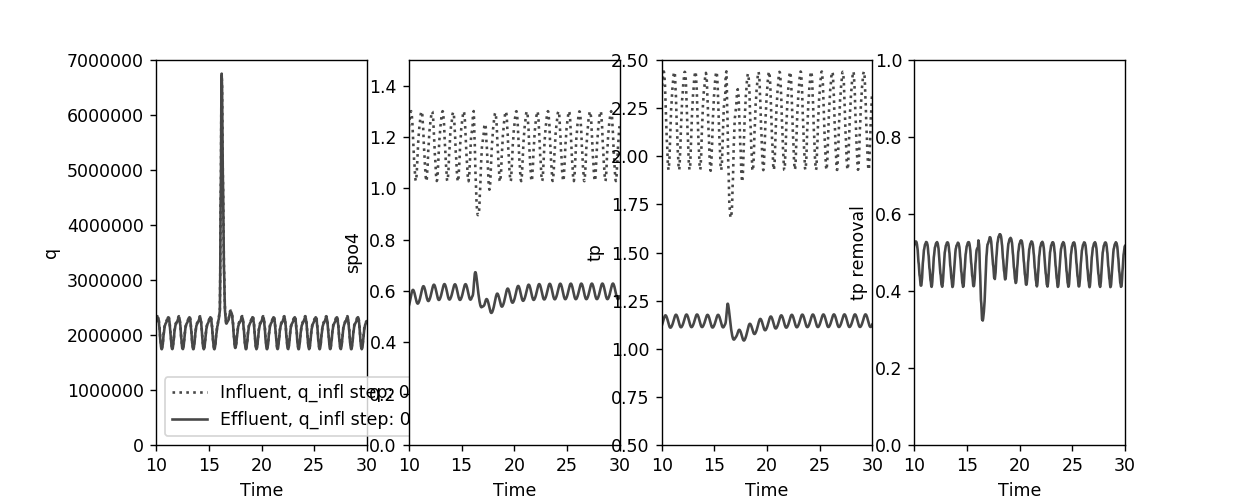

Step magnitude influent flow: 0

Step magnitude ferric chloride dose: 2.5

230021 TSV file "C:/Users/Sara/Desktop/sewerWRRF/data/storm1_nc_influent_edits.tsv" was not unloaded since it has not been loaded.
530030 TSV file "C:/Users/Sara/Desktop/sewerWRRF/data/storm1_nc_influent_edits.tsv" loaded.
530002 Simulation started.
530004 Simulation ended.


(0, 1)

In [7]:
# Initiate figure for timeseries plots
fig, axes = plt.subplots(1,4, figsize=(10,4))

for j in stepMags_inflq:
    for k in stepMags_femass:
        
        print('Step magnitude influent flow: ' + str(j) + '\n')
        print('Step magnitude ferric chloride dose: ' + str(k) + '\n')
    
        # Make a change to the original .tsv file
        r_influentTSV_data = pd.read_table(r_influentTSV, sep='\t')
        
        femass_steady = 0.
    
        #for i in range(0,20):
        #    r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i] = inflq_steady
        #for i in range(1100,1130):
        #    r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i] += 7000000
        
        #for i in range(0,30):
        #    r_influentTSV_data["Sumo__Plant__Metal1__param__Femass"].values[i] = femass_steady
        for i in range(0,int(stopTime_days*24*60/30)):
            r_influentTSV_data["Sumo__Plant__Metal1__param__Femass"].values[i] = 2*r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i]
            if r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i] > 2400000:
                r_influentTSV_data["Sumo__Plant__Metal1__param__Femass"].values[i] = k*r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i]
        
        
        # Write the changed .tsv file to a new file
        with open(w_influentTSV,'w') as write_tsv:
            write_tsv.write(r_influentTSV_data.to_csv(sep='\t', index=False))
        
        # Unload changed .tsv file to Sumo
        command = 'unloadtsv '+ w_influentTSV +' ;'
        sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
        
        # Load changed .tsv file to Sumo
        command = 'loadtsv '+ w_influentTSV +' ;'
        sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
        
        # Rerun Sumo simulation
        t_set = []
        q_infl_set = []; xtss_infl_set = []; spo4_infl_set = []; tp_infl_set = []
        q_effl_set = []; xtss_effl_set = []; spo4_effl_set = []; tp_effl_set = []
        
        sumo.run_model()
        
        while not sumo.simulation_finished:
            time.sleep(0.01)
        
        # Create dictionary of variables
        data_step = {}
        data_step['t'] = t_set
        data_step['q_infl'] = q_infl_set; data_step['q_effl'] = q_effl_set
        data_step['xtss_infl'] = xtss_infl_set; data_step['xtss_effl'] = xtss_effl_set
        data_step['spo4_infl'] = spo4_infl_set; data_step['spo4_effl'] = spo4_effl_set
        data_step['tp_infl'] = tp_infl_set; data_step['tp_effl'] = tp_effl_set
        
        # Create a pandas dataframe for this dictionary and index by time (t)
        df_step = pd.DataFrame.from_dict(data_step)
        df_step.set_index('t')
        
        # Store summaries
        femass_list.append(r_influentTSV_data["Sumo__Plant__Metal1__param__Femass"].values[-1])
        feconc_list.append(k)
        q_infl_list.append(data_step['q_infl'][-1]); q_effl_list.append(data_step['q_effl'][-1])
        xtss_infl_list.append(data_step['xtss_infl'][-1]); xtss_effl_list.append(data_step['xtss_effl'][-1])
        spo4_infl_list.append(data_step['spo4_infl'][-1]); spo4_effl_list.append(data_step['spo4_effl'][-1])
        tp_infl_list.append(data_step['tp_infl'][-1]); tp_effl_list.append(data_step['tp_effl'][-1])
        
        # Plot timeseries comparing influent and effluent of each step trial
        axes[0].plot(data_step['t'], data_step['q_infl'], ':', label="Influent, q_infl step: " + str(j) + ", femass: " + str(k), color = '#474747')
        axes[0].plot(data_step['t'], data_step['q_effl'], label="Effluent, q_infl step: " + str(j) + ", femass: " + str(k), color = '#474747')
        
        axes[1].plot(data_step['t'], data_step['spo4_infl'], ':', label="Influent, q_infl step: " + str(j) + ", femass: " + str(k), color = '#474747')
        axes[1].plot(data_step['t'], data_step['spo4_effl'], label="Effluent, q_infl step: " + str(j) + ", femass: " + str(k), color = '#474747')
        
        axes[2].plot(data_step['t'], data_step['tp_infl'], ':', label="Influent, q_infl step: " + str(j) + ", femass: " + str(k), color = '#474747')
        axes[2].plot(data_step['t'], data_step['tp_effl'], label="Effluent, q_infl step: " + str(j) + ", femass: " + str(k), color = '#474747')
        
        axes[3].plot(data_step['t'], np.divide(np.subtract(data_step['tp_infl'],data_step['tp_effl']), data_step['tp_infl']), label="Effluent, q_infl step: " + str(j) + ", femass: " + str(k), color = '#474747')

axes[0].set_xlabel('Time')
axes[0].set_ylabel('q')
axes[0].set_xlim(10,stopTime_days)
axes[0].set_ylim(0,7000000)
axes[0].legend()

axes[1].set_xlabel('Time')
axes[1].set_ylabel('spo4')
axes[1].set_xlim(10,stopTime_days)
axes[1].set_ylim(0.,1.5)
#axes[1].legend()

axes[2].set_xlabel('Time')
axes[2].set_ylabel('tp')
axes[2].set_xlim(10,stopTime_days)
axes[2].set_ylim(0.5,2.5)
#axes[2].legend()

axes[3].set_xlabel('Time')
axes[3].set_ylabel('tp removal')
axes[3].set_xlim(10,stopTime_days)
axes[3].set_ylim(0,1)
#axes[3].legend()

In [ ]:
data_step_summ = {}
data_step_summ['femass'] = femass_list; data_step_summ['feconc'] = feconc_list
data_step_summ['q_infl'] = q_infl_list; data_step_summ['q_effl'] = q_effl_list
data_step_summ['xtss_infl'] = xtss_infl_list; data_step_summ['xtss_effl'] = xtss_effl_list
data_step_summ['spo4_infl'] = spo4_infl_list; data_step_summ['spo4_effl'] = spo4_effl_list
data_step_summ['tp_infl'] = tp_infl_list; data_step_summ['tp_effl'] = tp_effl_list

df_step_summ = pd.DataFrame.from_dict(data_step_summ)

df_step_summ

In [ ]:
# Compare the step responses in spo4 effluent concentrations to the step increases in influent flow and ferric chloride dose
x = df_step_summ['q_infl']
y = df_step_summ['feconc']
z = df_step_summ['spo4_effl']

fig, ax = plt.subplots()
scat = ax.scatter(x, y, c=z, s=200, marker='o', cmap='inferno_r')
ax.set_xlabel('q_infl')
ax.set_ylabel('feconc')
cbar = fig.colorbar(scat)
cbar.ax.set_ylabel('spo4_effl')

In [ ]:
# Compare the step responses in spo4 effluent concentrations to the step increases in influent flow and ferric chloride dose
x = df_step_summ['q_infl']
y = df_step_summ['feconc']
z = df_step_summ['tp_effl']

fig, ax = plt.subplots()
scat = ax.scatter(x, y, c=z, s=200, marker='o', cmap='inferno_r')
ax.set_xlabel('q_infl')
ax.set_ylabel('feconc')
cbar = fig.colorbar(scat)
cbar.ax.set_ylabel('tp_effl')